<a href="https://colab.research.google.com/github/annsam0115/CIND820/blob/main/CIND820_CapstoneProject_ASAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries:

In [ ]:
import sys
!{sys.executable} -m pip install -U pandas-profiling
!jupyter nbextension enable --py widgetsnbextension
!pip install matplotlib

In [84]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from scipy import stats

from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import plotly 
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

#Data Preparation:

In [188]:
from google.colab import files
uploaded = files.upload()

Saving water_potability.csv to water_potability (4).csv


In [189]:
data = pd.read_csv("water_potability.csv")
df = pd.DataFrame(data)
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


We have NaN values. Must deal with those.

In [ ]:
df.shape

(3276, 10)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [ ]:
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [ ]:
df.nunique()

ph                 2785
Hardness           3276
Solids             3276
Chloramines        3276
Sulfate            2495
Conductivity       3276
Organic_carbon     3276
Trihalomethanes    3114
Turbidity          3276
Potability            2
dtype: int64

In [87]:
df['Potability'].value_counts()

0    1998
1    1278
Name: Potability, dtype: int64

There is an imbalance of data for the target variable. Non poptable samples have been oversampled versus the potatble samples. This will also need to be dealt with to ensure modeling is equal.

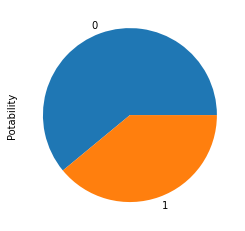

In [88]:
df.Potability.value_counts().plot(kind ='pie')

In [89]:
df.drop('Potability', axis=1).skew()

ph                 0.025630
Hardness          -0.039342
Solids             0.621634
Chloramines       -0.012098
Sulfate           -0.035947
Conductivity       0.264490
Organic_carbon     0.025533
Trihalomethanes   -0.083031
Turbidity         -0.007817
dtype: float64

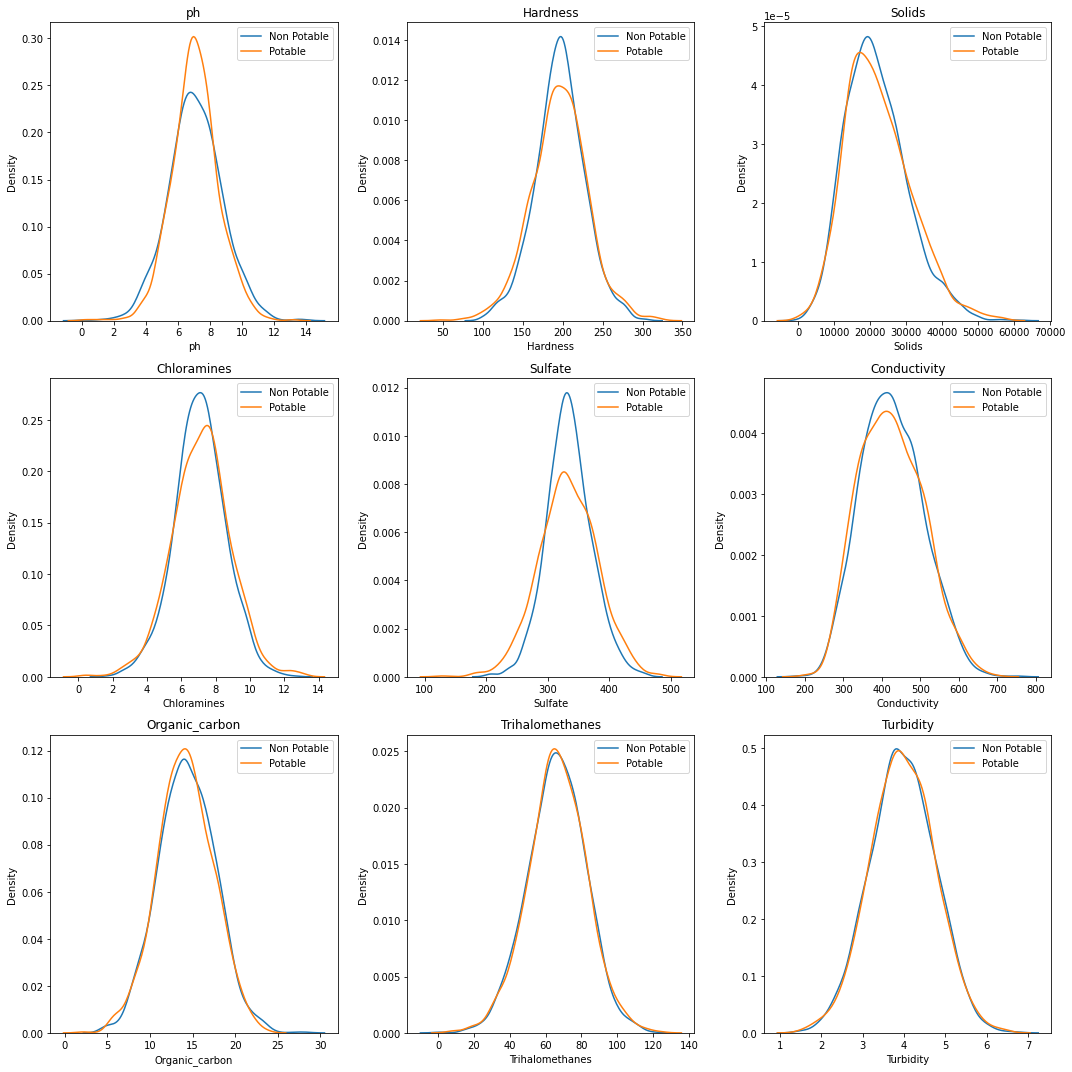

In [90]:
non_potable = df[df['Potability'] == 0]
potable = df[df['Potability'] == 1]

plt.figure(figsize=(15,15))

for ax,col in enumerate(df.columns[:9]):
    plt.subplot(3,3,ax+1)
    plt.title(col)
    sns.kdeplot(x=non_potable[col],label = "Non Potable")
    sns.kdeplot(x=potable[col],label = "Potable")
    plt.legend()
    
plt.tight_layout()

Distirbution of the data is mostly Gaussian.

In [91]:
df.corr()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.082096,-0.089288,-0.034350,0.018203,0.018614,0.043503,0.003354,-0.039057,-0.003556
Hardness,0.082096,1.000000,-0.046899,-0.030054,-0.106923,-0.023915,0.003610,-0.013013,-0.014449,-0.013837
Solids,-0.089288,-0.046899,1.000000,-0.070148,-0.171804,0.013831,0.010242,-0.009143,0.019546,0.033743
Chloramines,-0.034350,-0.030054,-0.070148,1.000000,0.027244,-0.020486,-0.012653,0.017084,0.002363,0.023779
Sulfate,0.018203,-0.106923,-0.171804,0.027244,1.000000,-0.016121,0.030831,-0.030274,-0.011187,-0.023577
Conductivity,0.018614,-0.023915,0.013831,-0.020486,-0.016121,1.000000,0.020966,0.001285,0.005798,-0.008128
Organic_carbon,0.043503,0.003610,0.010242,-0.012653,0.030831,0.020966,1.000000,-0.013274,-0.027308,-0.030001
Trihalomethanes,0.003354,-0.013013,-0.009143,0.017084,-0.030274,0.001285,-0.013274,1.000000,-0.022145,0.007130
Turbidity,-0.039057,-0.014449,0.019546,0.002363,-0.011187,0.005798,-0.027308,-0.022145,1.000000,0.001581
Potability,-0.003556,-0.013837,0.033743,0.023779,-0.023577,-0.008128,-0.030001,0.007130,0.001581,1.000000


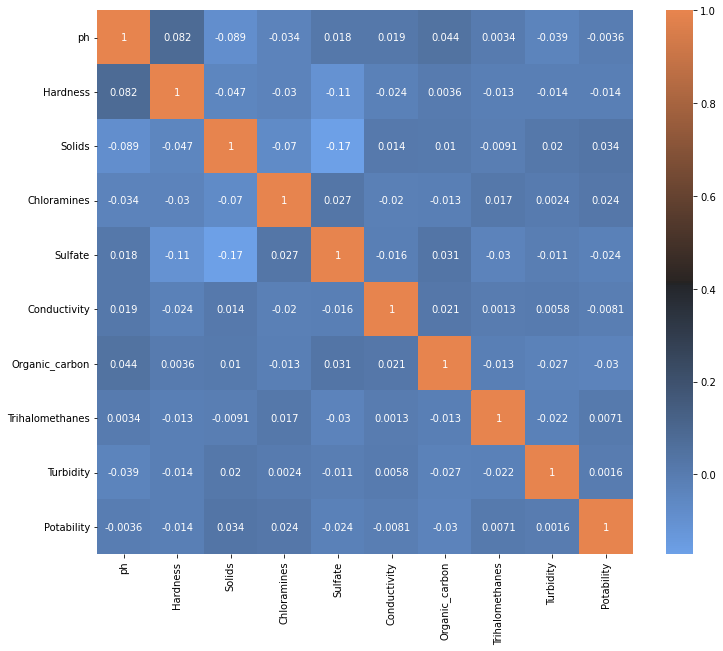

In [95]:
plt.figure(figsize = (12,10))
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
sns.heatmap(df.corr(), annot = True, cmap=cmap)

In [93]:
df.corr().abs()['Potability'].sort_values(ascending = False)

Potability         1.000000
Solids             0.033743
Organic_carbon     0.030001
Chloramines        0.023779
Sulfate            0.023577
Hardness           0.013837
Conductivity       0.008128
Trihalomethanes    0.007130
ph                 0.003556
Turbidity          0.001581
Name: Potability, dtype: float64

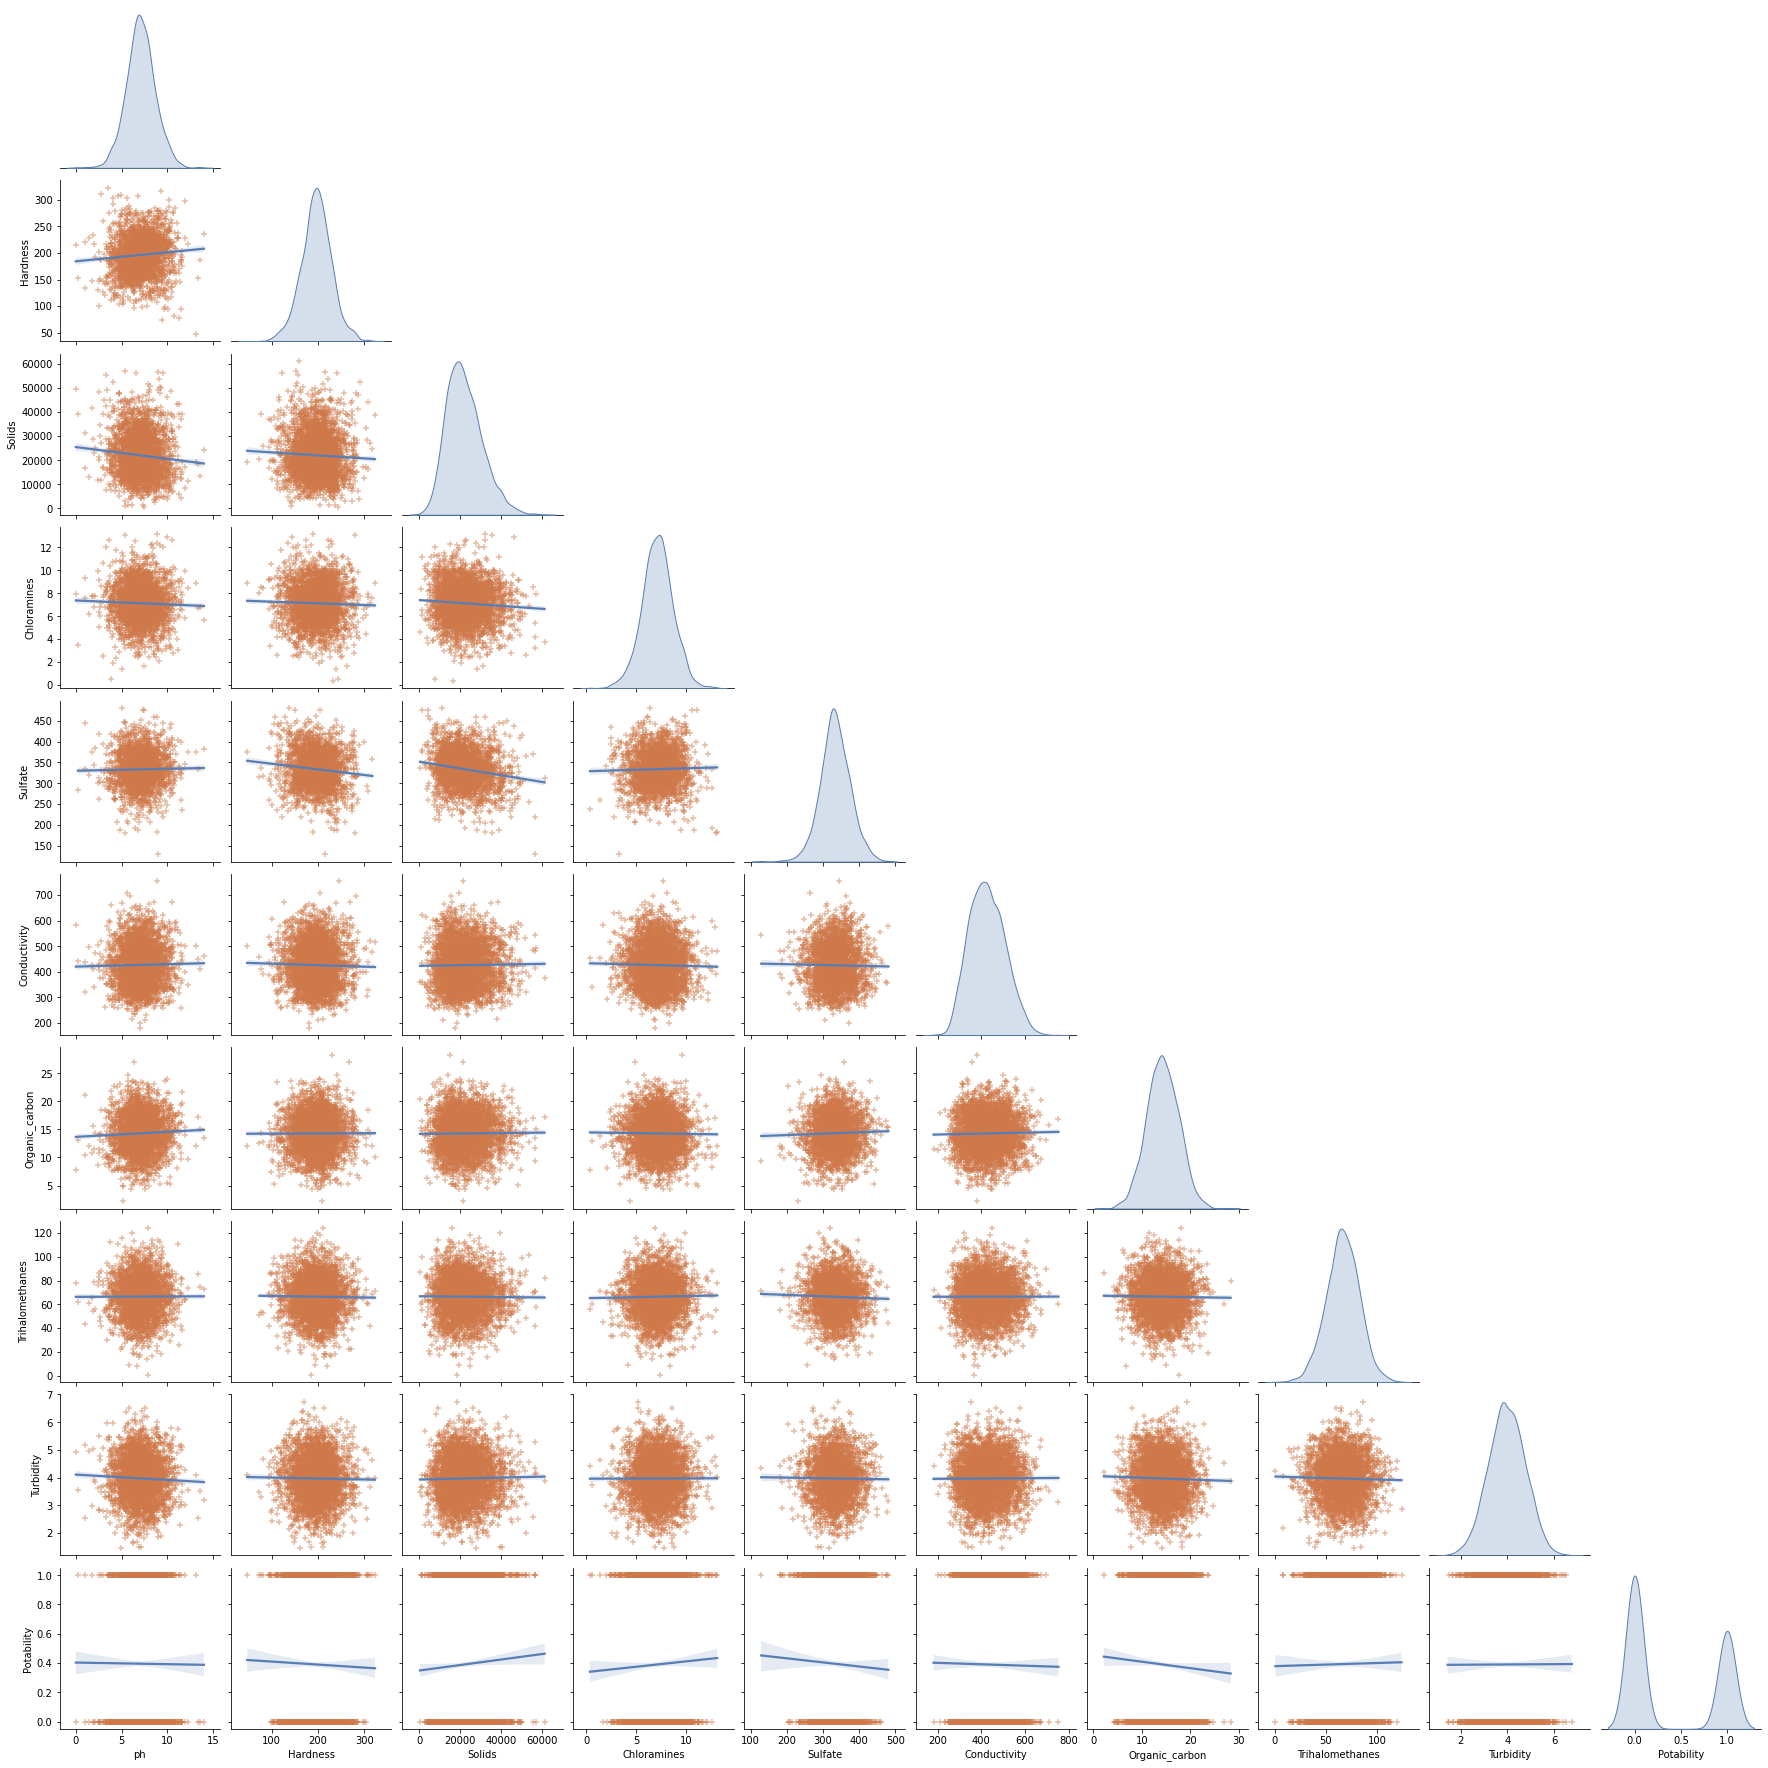

In [94]:
sns.pairplot(df, markers="+",
                 kind='reg',
                 diag_kind="kde",
                 plot_kws={'line_kws':{'color':'#597eb3'},
                           'scatter_kws': {'alpha': 0.5,
                                           'color': '#cf7849'}},
                 corner=True,
                 diag_kws= {'color': '#597eb3'})

Both the correlation heatmap and pairplots between the variables show that there are no clear linear relationships between the features and the target variable. We can rule out using a simple linear model.

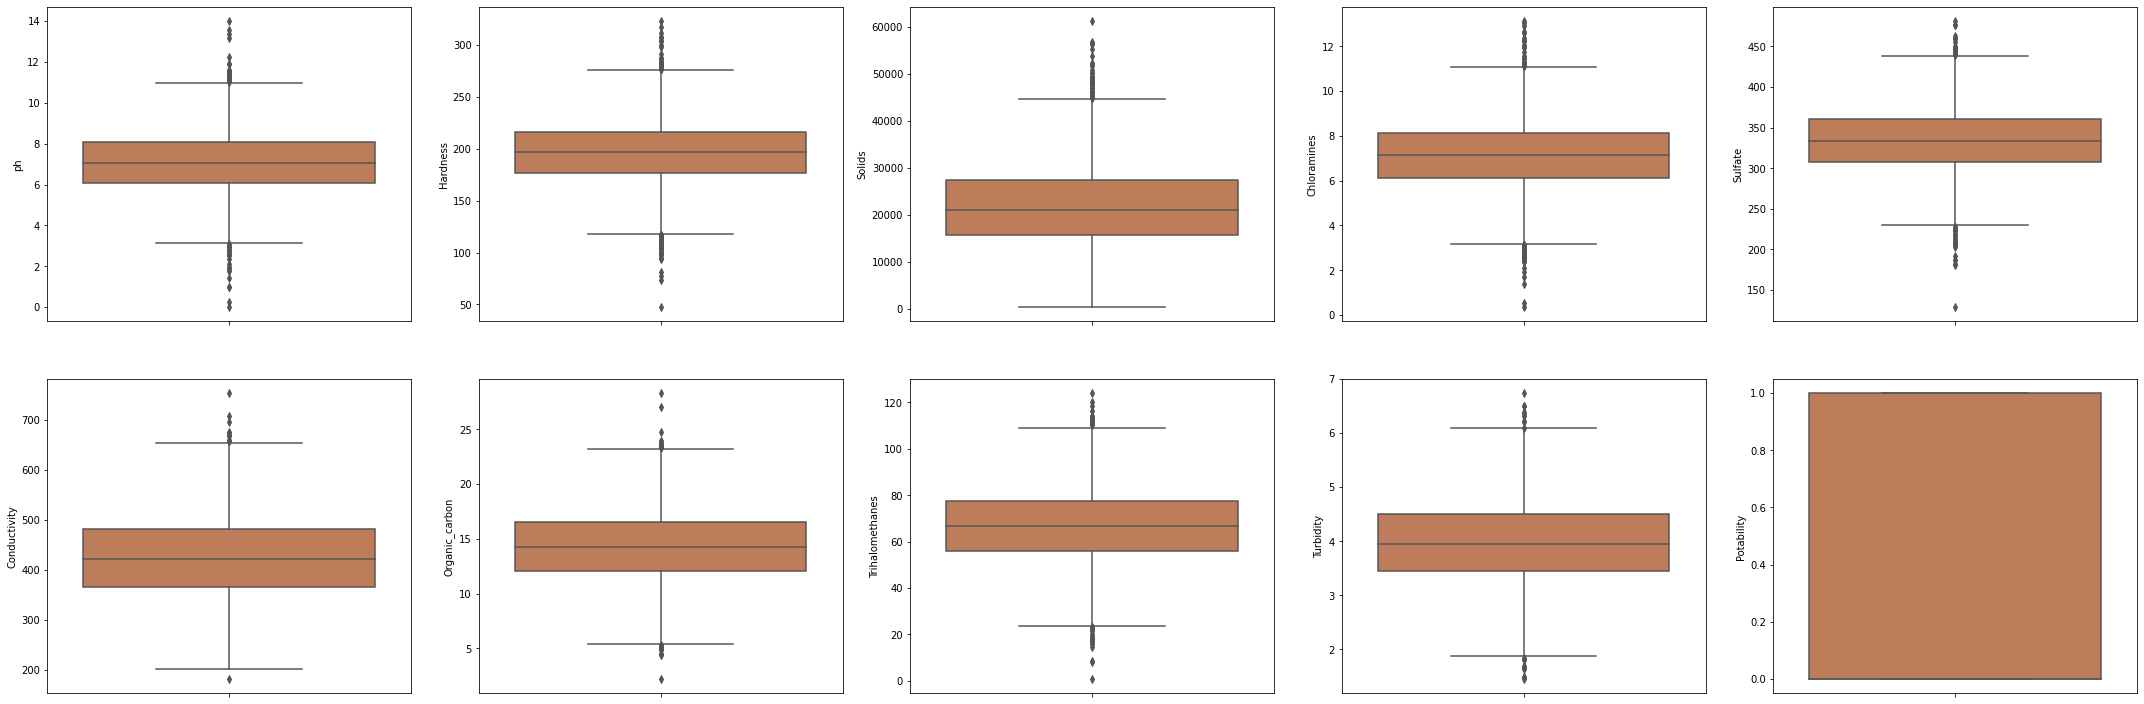

In [97]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(30,10))
index = 0
ax = ax.flatten()

for attributeCol, value in df.items():
    sns.boxplot(y=attributeCol, data=df, ax=ax[index], color="#cf7849")
    index += 1
plt.tight_layout(pad=1.5, w_pad=1.5, h_pad=5.0)

There are outliers within every feature of the dataset.

#Dealing with Class Imbalance

In [190]:
df1 = df.copy()

zero  = df1[df1['Potability']==0]   #oversampled
one = df1[df1['Potability']==1]  #undersampled

from sklearn.utils import resample
zero_balanced = resample(zero, replace = False, n_samples = 1278, random_state=0) 
#concatenate
df1 = pd.concat([one, zero_balanced])

In [191]:
df1['Potability'].value_counts()

1    1278
0    1278
Name: Potability, dtype: int64

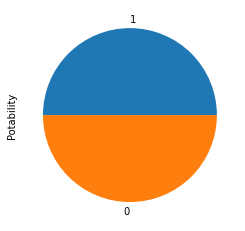

In [192]:
df1.Potability.value_counts().plot(kind ='pie')

#Dealing with Missing Values

In [193]:
df1.isna().any().any()

True

In [194]:
df1.isnull().sum()

ph                 367
Hardness             0
Solids               0
Chloramines          0
Sulfate            598
Conductivity         0
Organic_carbon       0
Trihalomethanes    125
Turbidity            0
Potability           0
dtype: int64

In [195]:
df1.isnull().mean()*100 

ph                 14.358372
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.395931
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.890454
Turbidity           0.000000
Potability          0.000000
dtype: float64

In [196]:
df1[df1['Potability']==0][['ph','Sulfate','Trihalomethanes']].mean()

ph                   7.082654
Sulfate            333.667156
Trihalomethanes     65.870529
dtype: float64

In [197]:
df1[df1['Potability']==1][['ph','Sulfate','Trihalomethanes']].mean()

ph                   7.073783
Sulfate            332.566990
Trihalomethanes     66.539684
dtype: float64

The three features with missing values all have Gaussian distribution therefore it is a safe assumption to use the mean of each feature to fill in for the missing values.

In [198]:
df_water = df1.copy()
df_water['ph'].fillna(value=df_water['ph'].mean(),inplace=True)
df_water['Sulfate'].fillna(value=df_water['Sulfate'].mean(),inplace=True)
df_water['Trihalomethanes'].fillna(value=df_water['Trihalomethanes'].mean(),inplace=True)

In [199]:
df_water.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

In [200]:
df_water.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000,2556.000000
mean,7.078192,196.423954,22213.640001,7.122604,333.113702,426.864401,14.211054,66.207171,3.978443,0.500000
std,1.462938,33.535824,8892.153696,1.622488,37.016040,80.994153,3.258889,15.985388,0.790182,0.500098
min,0.000000,47.432000,728.750830,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.280960,176.651739,15761.088680,6.109894,316.523057,365.811312,12.033626,55.980034,3.452654,0.000000
50%,7.078192,197.251672,21150.782366,7.128299,333.113702,422.544985,14.154532,66.207171,3.964568,0.500000
75%,7.853132,217.370504,27421.696216,8.132722,350.459408,482.322362,16.402874,76.540062,4.512549,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,708.226364,27.006707,124.000000,6.739000,1.000000


#Dealing with Outliers

In [201]:
df_water_trim = df_water.copy()

In [202]:
df_water_trim

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
250,9.445130,145.805402,13168.529156,9.444471,310.583374,592.659021,8.606397,77.577460,3.875165,1
251,9.024845,128.096691,19859.676476,8.016423,300.150377,451.143481,14.770863,73.778026,3.985251,1
252,7.078192,169.974849,23403.637304,8.519730,333.113702,475.573562,12.924107,50.861913,2.747313,1
253,6.800119,242.008082,39143.403329,9.501695,187.170714,376.456593,11.432466,73.777275,3.854940,1
254,7.174135,203.408935,20401.102461,7.681806,287.085679,315.549900,14.533510,74.405616,3.939896,1
...,...,...,...,...,...,...,...,...,...,...
2625,7.683157,221.575347,25475.884844,9.914966,333.113702,372.803909,12.054439,51.892500,4.781323,0
2199,7.078192,229.725348,22444.559412,5.702175,320.990051,389.030889,15.501543,34.246212,3.851154,0
942,6.848805,204.812711,20555.559572,9.775004,387.686388,389.638228,12.298753,49.452046,3.130045,0
2987,3.730128,230.299455,16892.895662,6.997172,323.520471,456.905704,10.342146,47.095506,4.943032,0


In [203]:
df_water_trim = df_water_trim[(np.abs(stats.zscore(df_water)) <= 3).all(axis=1)]

Since the features have Gaussian distribution we can trim out the outliers data outside of 3 standard deviations.

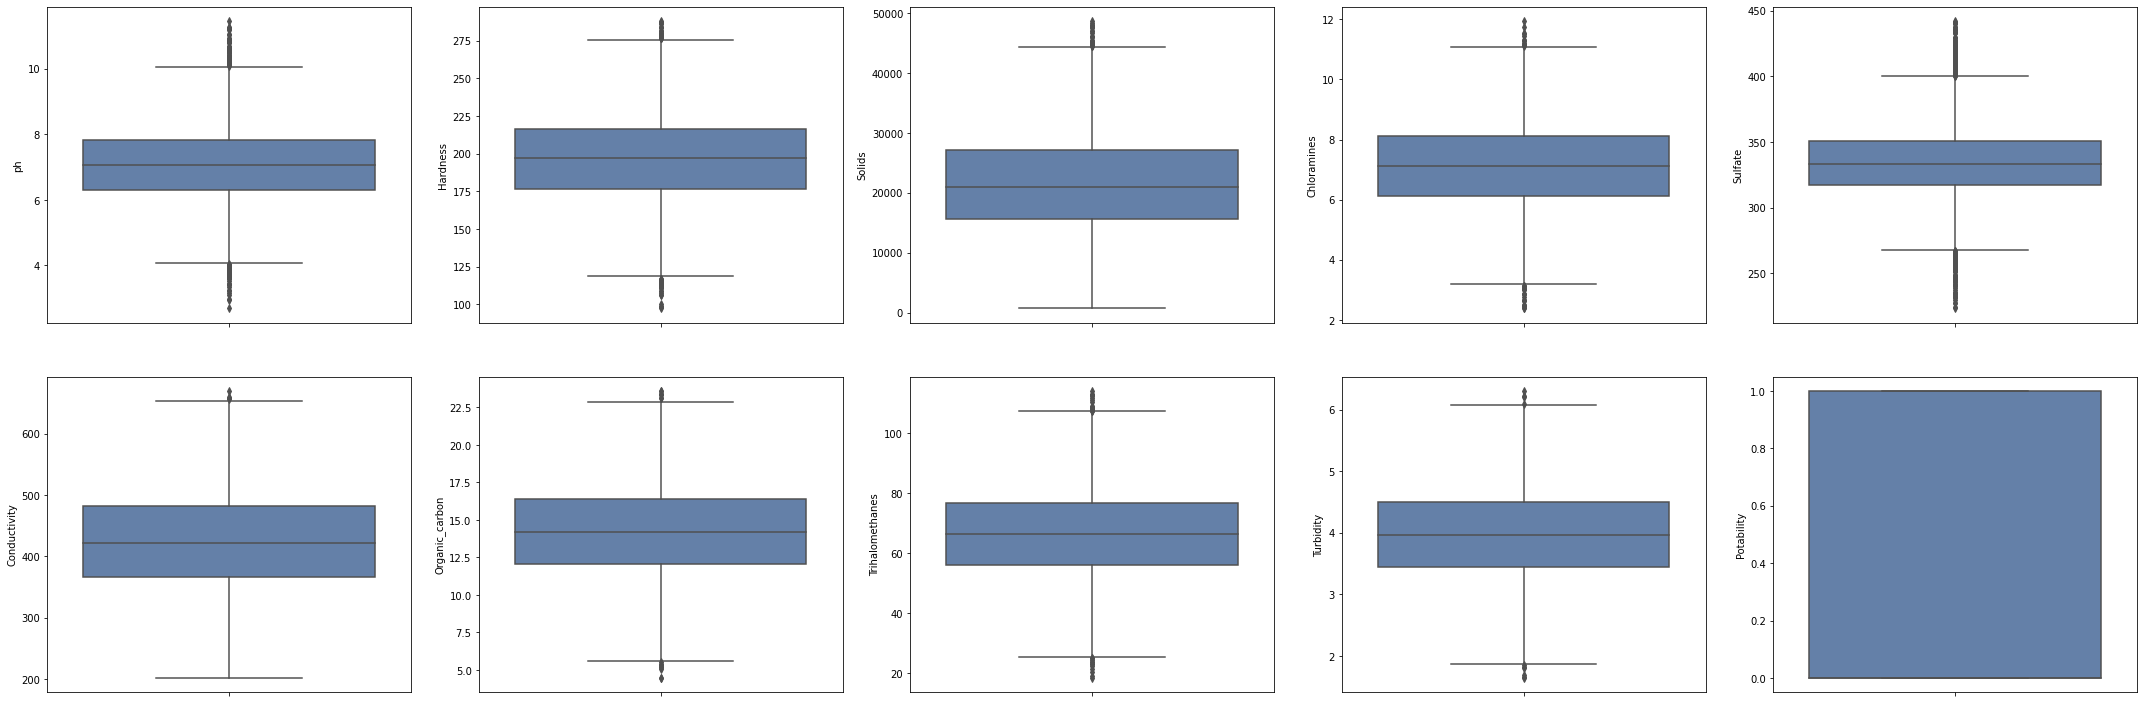

In [170]:
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(30,10))
index = 0
ax = ax.flatten()

for attributeCol, value in df_water_trim.items():
    sns.boxplot(y=attributeCol, data=df_water_trim, ax=ax[index], color='#597eb3')
    index += 1
plt.tight_layout(pad=1.5, w_pad=1.5, h_pad=5.0)

In [171]:
df_water_trim[df_water_trim.index.duplicated()]

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability


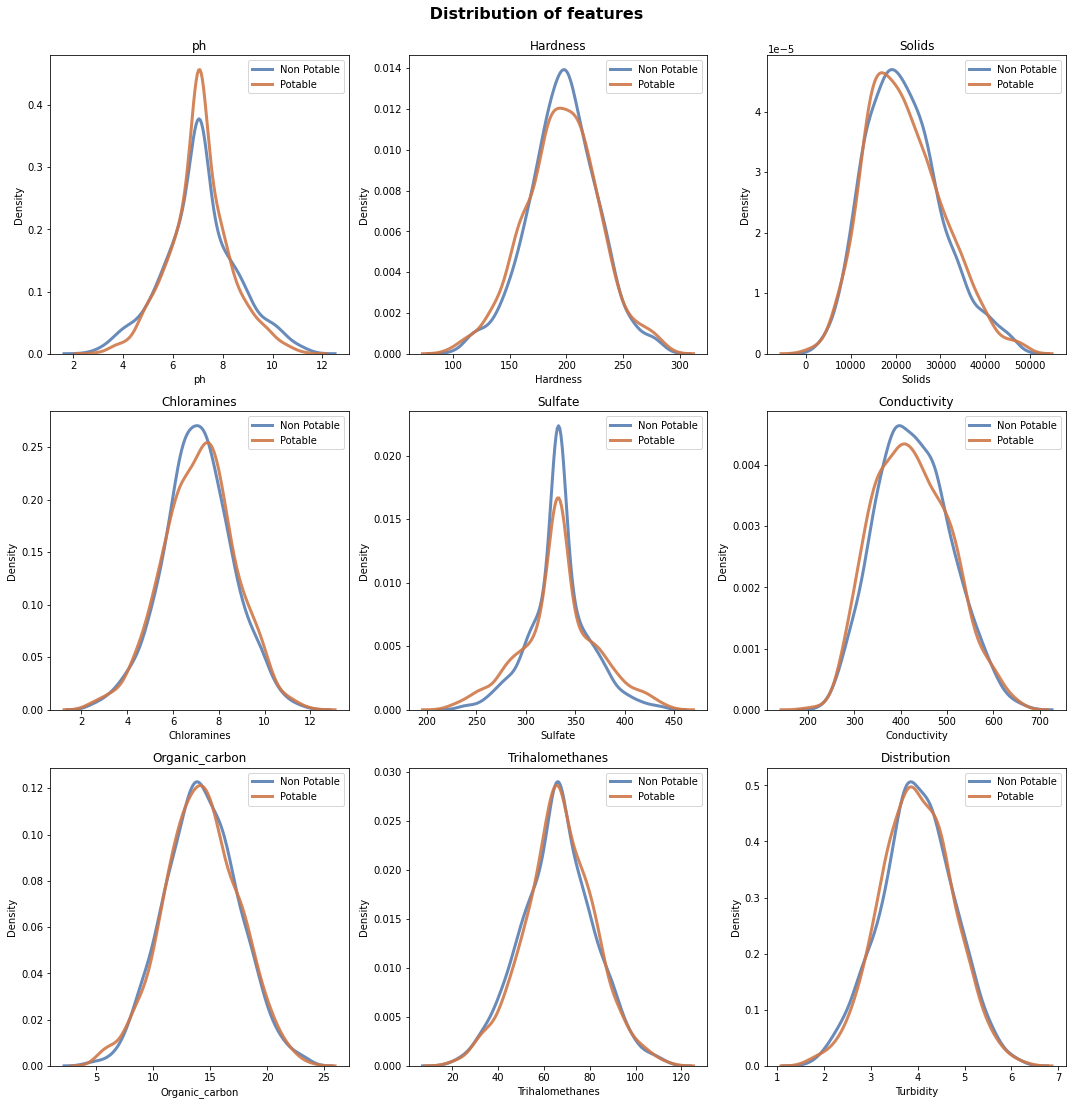

In [172]:
non_potable = df_water_trim.query("Potability == 0")
potable = df_water_trim.query("Potability == 1")

plt.figure(figsize = (15,15))
for ax, col in enumerate(df_water_trim.columns[:9]):
    plt.subplot(3,3, ax + 1)
    plt.title(col)
    plotting = sns.kdeplot(x = non_potable[col], label = "Non Potable",fill=False, common_norm=False, color='#597eb3', alpha=.9, linewidth=3)
    plotting = sns.kdeplot(x = potable[col], label = "Potable",fill=False, common_norm=False, color='#cf7849', alpha=.9, linewidth=3)
    plt.legend()
plt.tight_layout()
plt.title('Distribution')
plotting.figure.suptitle(' Distribution of features ',y=1.02, size = 16, weight='bold');

Text(0.5, 1.01, 'Water Quality')

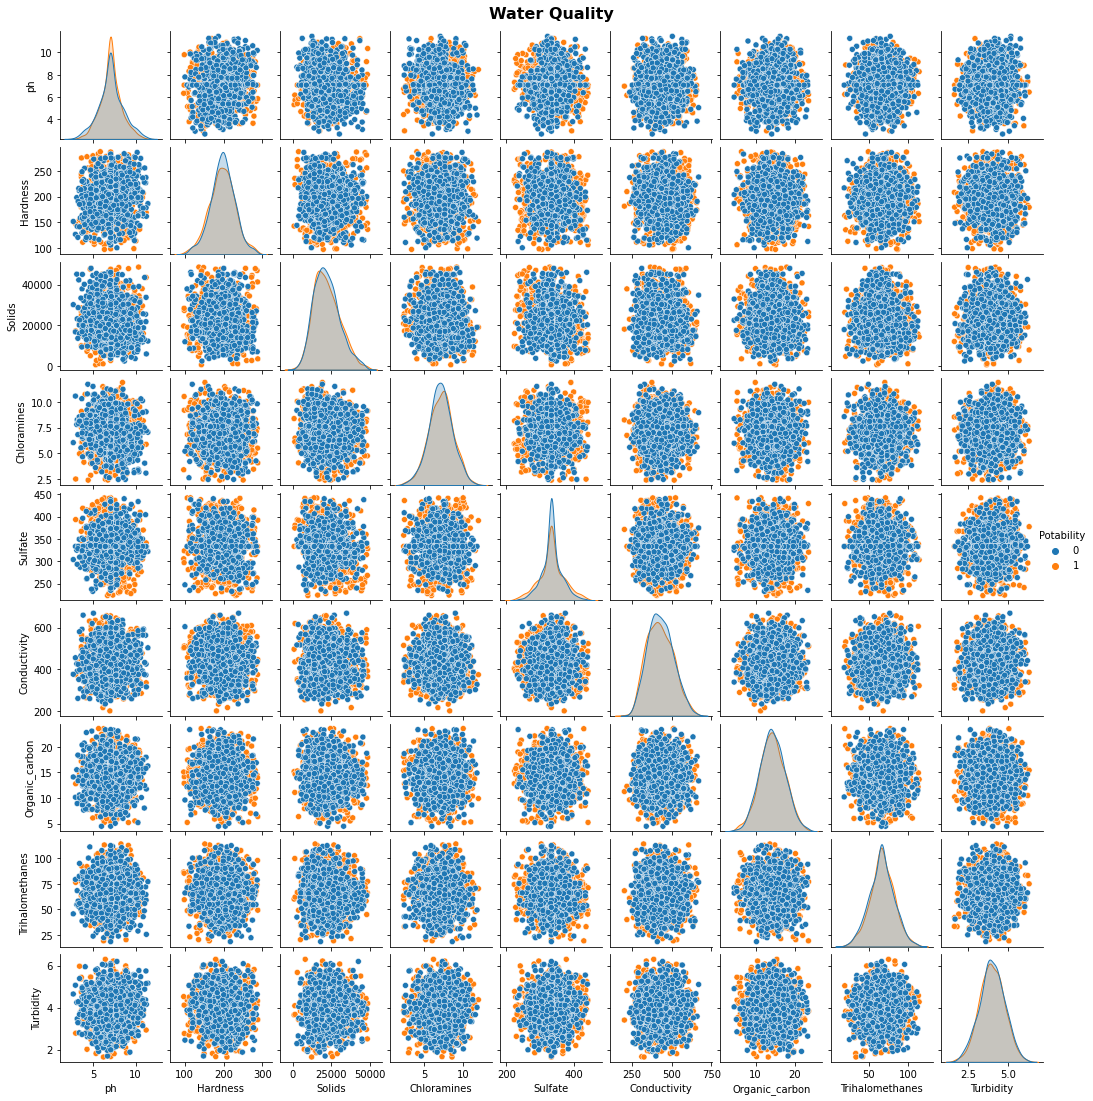

In [173]:
ax = sns.pairplot(df_water_trim, hue = "Potability", diag_kind = "kde", kind = "scatter")
ax.fig.set_size_inches(15,15)
ax.fig.suptitle('Water Quality',y=1.01, size = 16, color = 'black', weight='bold')

After balancing the data, dealing with the outliers and the missing data, we can still see that the data has remained relatively similar in distribution.

#Exploring dimensionalty reduction using PCA:

In [373]:
from sklearn.model_selection import train_test_split

X = df_water_trim.drop('Potability',axis=1)
y = df_water_trim['Potability']

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

No handles with labels found to put in legend.


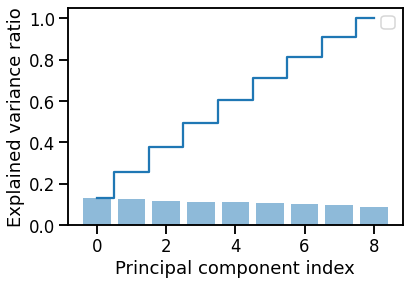

In [374]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

pca = PCA()

X_train_pca = pca.fit_transform(X_train_std)
exp_var_pca = pca.explained_variance_ratio_

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5)
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend()
plt.show()

PCA tells us that all the features are independent and confirm our previous observations from the correlation matrix and heatmap that there are not linear relationships between the features. This PCA analysis of explained variance ratio tells us that even with 7 components, it can only explain 80% of the variance. Therefore, dimensionality reduction will not increase any performance from our modeling.

#Preprocessing: Train-test split and standardized scaler

In [375]:
from sklearn.model_selection import train_test_split

X = df_water_trim.drop('Potability',axis=1)
y = df_water_trim['Potability']

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scale = StandardScaler()
X_train=scale.fit_transform(X_train)
X_test=scale.transform(X_test)

In [376]:
print("X_train:", X_train.shape, "\ny_train:", y_train.shape)
print("X_test:", X_test.shape, "\ny_test:", y_test.shape)

X_train: (1950, 9) 
y_train: (1950,)
X_test: (488, 9) 
y_test: (488,)


#Hyper-tunning parameters

In [402]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
xgb =XGBClassifier(eval_metric = 'logloss', use_label_encoder=False)

In [403]:
para_knn = {'n_neighbors':np.arange(1, 50)}
grid_knn = GridSearchCV(knn, param_grid=para_knn, cv=5)
grid_knn.fit(X_train, y_train)
print("Best parameters for KNN:", grid_knn.best_params_)

Best parameters for KNN: {'n_neighbors': 48}


In [404]:
para_dt = {'criterion':['gini','entropy'],'max_depth':np.arange(1, 50), 'min_samples_leaf':[1,2,4,5,10,20,30,40,80,100]}
grid_dt = GridSearchCV(dt, param_grid=para_dt, cv=5) 
grid_dt.fit(X_train, y_train)
print("Best parameters for Decision Tree:", grid_dt.best_params_)

Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 40}


In [405]:
params_rf = {'n_estimators':[100,200, 350, 500], 'min_samples_leaf':[2, 10, 30]}
grid_rf = GridSearchCV(rf, param_grid=params_rf, cv=5)
grid_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:", grid_rf.best_params_)

Best parameters for Random Forest: {'min_samples_leaf': 2, 'n_estimators': 500}


In [436]:
params_svc = {'C': [0.1, 1, 10, 100, 1000], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
grid_svc = GridSearchCV(SVC(), param_grid=params_svc, refit = True, verbose = 3)
grid_svc.fit(X_train, y_train)
print("Best parameters for SVM:", grid_svc.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.515 total time=   0.3s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.515 total time=   0.3s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.515 total time=   0.3s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.513 total time=   0.3s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.513 total time=   0.3s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.595 total time=   0.3s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.592 total time=   0.3s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.608 total time=   0.3s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.569 total time=   0.3s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.587 total time=   0.3s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.515 total time=   0.3s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

In [406]:
params_xgb = {'n_estimators': [50,100,250,400,600,800,1000], 'learning_rate': [0.2,0.5,0.8,1]}
rs_xgb =  RandomizedSearchCV(xgb, param_distributions=params_xgb, cv=5)
rs_xgb.fit(X_train, y_train)
print("Best parameters for XGBoost:", rs_xgb.best_params_)

Best parameters for XGBoost: {'n_estimators': 600, 'learning_rate': 0.8}


#Predictive Modeling/Classication:

In [295]:
#score
from sklearn.metrics import precision_score, accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix, classification_report

#models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

#1. Logistic Regression

In [411]:
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)
LogReg_pred = LogReg.predict(X_test)
LogReg_acc = accuracy_score(y_test, LogReg_pred)
LogReg_mae = mean_absolute_error(y_test, LogReg_pred)
LogReg_mse = mean_squared_error(y_test, LogReg_pred)
LogReg_rmse = np.sqrt(mean_squared_error(y_test, LogReg_pred))
LogReg_precision = precision_score(y_test, LogReg_pred) 

In [410]:
print("The accuracy for Logistic Regression is", LogReg_acc)
print("The classification report using Logistic Regression is:")
print(classification_report(y_test, LogReg_pred))

The accuracy for Logistic Regression is 0.46311475409836067
The classification report using Logistic Regression is:
              precision    recall  f1-score   support

         0.0       0.45      0.68      0.54       229
         1.0       0.49      0.27      0.35       259

    accuracy                           0.46       488
   macro avg       0.47      0.48      0.45       488
weighted avg       0.47      0.46      0.44       488



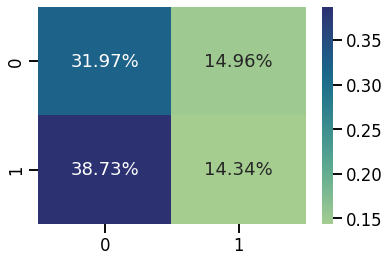

In [432]:
LogReg_cm = confusion_matrix(y_test, LogReg_pred)
sns.heatmap(LogReg_cm/np.sum(LogReg_cm), annot = True, fmt = '0.2%', cmap = 'crest')

#2. K-Nearest Neighbour Regression

In [412]:
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier(n_neighbors = 48)
KNN.fit(X_train, y_train)
KNN_pred = KNN.predict(X_test)
KNN_acc = accuracy_score(y_test, KNN_pred)
KNN_mae = mean_absolute_error(y_test, KNN_pred)
KNN_mse = mean_squared_error(y_test, KNN_pred)
KNN_rmse = np.sqrt(mean_squared_error(y_test, KNN_pred))
KNN_precision = precision_score(y_test, KNN_pred) 

In [413]:
print("The accuracy for KNeighbors is", KNN_acc)
print("The classification report using KNeighbors is:", KNN_acc)
print(classification_report(y_test, KNN_pred))

The accuracy for KNeighbors is 0.5635245901639344
The classification report using KNeighbors is: 0.5635245901639344
              precision    recall  f1-score   support

         0.0       0.53      0.71      0.60       229
         1.0       0.63      0.44      0.51       259

    accuracy                           0.56       488
   macro avg       0.58      0.57      0.56       488
weighted avg       0.58      0.56      0.56       488



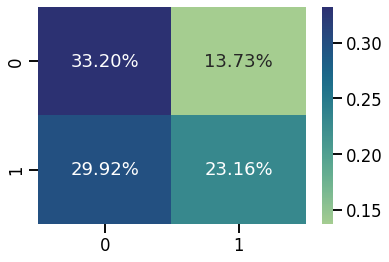

In [414]:
KNN_cm = confusion_matrix(y_test, KNN_pred)
sns.heatmap(KNN_cm/np.sum(KNN_cm), annot = True, fmt = '0.2%', cmap = 'crest')

#3. Decision Tree Classifier

In [415]:
from sklearn.tree import DecisionTreeClassifier

DecTree = DecisionTreeClassifier(max_depth = 7, min_samples_leaf = 40, criterion ='entropy')
DecTree.fit(X_train, y_train)
DecTree_pred = DecTree.predict(X_test)
DecTree_acc = accuracy_score(y_test, DecTree_pred)
DecTree_mae = mean_absolute_error(y_test, DecTree_pred)
DecTree_mse = mean_squared_error(y_test, DecTree_pred)
DecTree_rmse = np.sqrt(mean_squared_error(y_test, DecTree_pred))
DecTree_precision = precision_score(y_test, DecTree_pred) 

In [416]:
print("The accuracy for Decision Tree is", DecTree_acc)
print("The classification report using Decision Tree is:")
print(classification_report(y_test, DecTree_pred))

The accuracy for Decision Tree is 0.5717213114754098
The classification report using Decision Tree is:
              precision    recall  f1-score   support

         0.0       0.53      0.72      0.61       229
         1.0       0.64      0.44      0.52       259

    accuracy                           0.57       488
   macro avg       0.59      0.58      0.57       488
weighted avg       0.59      0.57      0.56       488



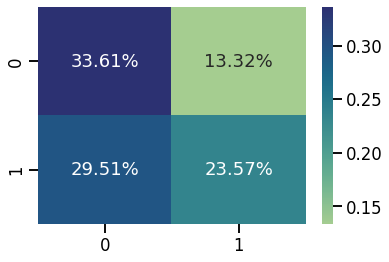

In [417]:
DecTree_cm = confusion_matrix(y_test, DecTree_pred)
sns.heatmap(DecTree_cm/np.sum(DecTree_cm), annot = True, fmt = '0.2%', cmap = 'crest')

#4. Random Forest Classifier

In [418]:
from sklearn.ensemble import RandomForestClassifier

RFTree = RandomForestClassifier(n_estimators =500, min_samples_leaf =2)
RFTree.fit(X_train, y_train)
RFTree_pred = RFTree.predict(X_test)
RFTree_acc = accuracy_score(y_test, RFTree_pred)
RFTree_mae = mean_absolute_error(y_test, RFTree_pred)
RFTree_mse = mean_squared_error(y_test, RFTree_pred)
RFTree_rmse = np.sqrt(mean_squared_error(y_test, RFTree_pred))
RFTree_precision = precision_score(y_test, RFTree_pred) 

In [419]:
print("The accuracy for Random Forest is", RFTree_acc)
print("The classification report using Random Forest is:")
print(classification_report(y_test, RFTree_pred))

The accuracy for Random Forest is 0.5942622950819673
The classification report using Random Forest is:
              precision    recall  f1-score   support

         0.0       0.56      0.65      0.60       229
         1.0       0.64      0.54      0.59       259

    accuracy                           0.59       488
   macro avg       0.60      0.60      0.59       488
weighted avg       0.60      0.59      0.59       488



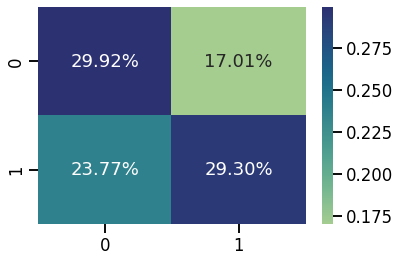

In [387]:
RFTree_cm = confusion_matrix(y_test, RFTree_pred)
sns.heatmap(RFTree_cm/np.sum(RFTree_cm), annot = True, fmt = '0.2%', cmap = 'crest')

#5. Support Vector Model Classifier

In [437]:
from sklearn.svm import SVC, LinearSVC

SVM = SVC(C = 1, gamma = 0.1, kernel = 'rbf')
SVM.fit(X_train, y_train)
SVM_pred = SVM.predict(X_test)
SVM_acc = accuracy_score(y_test, SVM_pred)
SVM_mae = mean_absolute_error(y_test, SVM_pred)
SVM_mse = mean_squared_error(y_test, SVM_pred)
SVM_rmse = np.sqrt(mean_squared_error(y_test, SVM_pred))
SVM_precision = precision_score(y_test, SVM_pred) 

In [438]:
print("The accuracy for SVM is", SVM_acc)
print("The classification report using SVM is:", SVM_acc)
print(classification_report(y_test, SVM_pred))

The accuracy for SVM is 0.6024590163934426
The classification report using SVM is: 0.6024590163934426
              precision    recall  f1-score   support

         0.0       0.56      0.70      0.62       229
         1.0       0.66      0.52      0.58       259

    accuracy                           0.60       488
   macro avg       0.61      0.61      0.60       488
weighted avg       0.61      0.60      0.60       488



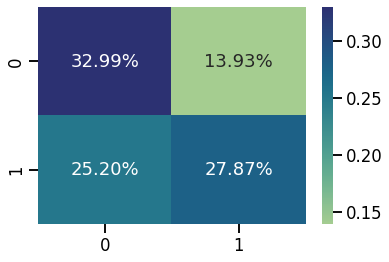

In [426]:
SVM_cm = confusion_matrix(y_test, SVM_pred)
sns.heatmap(SVM_cm/np.sum(SVM_cm), annot = True, fmt = '0.2%', cmap = 'crest')

#6. XGBoost Classifier

In [420]:
from xgboost import XGBClassifier

XGB = XGBClassifier(n_estimators = 600, learning_rate = 0.8)
XGB.fit(X_train, y_train)
XGB_pred = XGB.predict(X_test)
XGB_acc = accuracy_score(y_test, XGB_pred)
XGB_mae = mean_absolute_error(y_test, XGB_pred)
XGB_mse = mean_squared_error(y_test, XGB_pred)
XGB_rmse = np.sqrt(mean_squared_error(y_test, XGB_pred))
XGB_precision = precision_score(y_test, XGB_pred) 

In [421]:
print("The accuracy for XGBoost is", XGB_acc)
print("The classification report using XGBoost is:", XGB_acc)
print(classification_report(y_test, XGB_pred))

The accuracy for XGBoost is 0.5676229508196722
The classification report using XGBoost is: 0.5676229508196722
              precision    recall  f1-score   support

         0.0       0.54      0.58      0.56       229
         1.0       0.60      0.56      0.58       259

    accuracy                           0.57       488
   macro avg       0.57      0.57      0.57       488
weighted avg       0.57      0.57      0.57       488



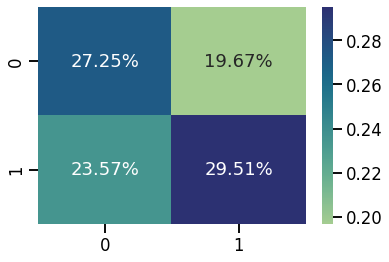

In [422]:
XGB_cm = confusion_matrix(y_test, XGB_pred)
sns.heatmap(XGB_cm/np.sum(XGB_cm), annot = True, fmt = '0.2%', cmap = 'crest')

#Comparing Models:

In [1]:
models = [
    ('Logistic Regression', LogisticRegression()),
    ('KNN Regression', KNeighborsClassifier(n_neighbors = 48)),
    ('Decision Tree', DecisionTreeClassifier(max_depth = 7, min_samples_leaf = 40, criterion ='entropy')),
    ('Random Forest Classifier', RandomForestClassifier(n_estimators =500, min_samples_leaf =2)),
    ('Support Vector Classifier', SVC(C = 1, gamma = 0.1, kernel = 'rbf')),
    ('XGB Classifier', XGBClassifier(n_estimators = 600, learning_rate = 0.8)),
]

results = dict()
for name, model in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
        
    score = accuracy_score(y_test, pred)    
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    precision = precision_score(y_test, pred) 
    results[name] = score, mae, mse, rmse, precision

NameError: ignored

In [428]:
models = pd.DataFrame({
    'Model':['Logistic Regression', 'KNN Regression', 'Decision Tree', 'Random Forest', 'Support Vector', 'XGBoost'],
    'Accuracy' :[LogReg_acc, KNN_acc, DecTree_acc, RFTree_acc, SVM_acc, XGB_acc],
    'Mean Absolute Error' :[LogReg_mae, KNN_mae, DecTree_mae, RFTree_mae, SVM_mae, XGB_mae],
    'Mean Squared Error' :[LogReg_mse, KNN_mse, DecTree_mse, RFTree_mse, SVM_mse, XGB_mse],    
    'Root Mean Squared Error' :[LogReg_rmse, KNN_rmse, DecTree_rmse, RFTree_rmse, SVM_rmse, XGB_rmse],
    'Precision' :[LogReg_precision, KNN_precision, DecTree_precision, RFTree_precision, SVM_precision, XGB_precision],
})
models = models.sort_values(by='Accuracy', ascending=False)

In [441]:
models

[('Logistic Regression', LogisticRegression()),
 ('KNN Regression', KNeighborsClassifier(n_neighbors=48)),
 ('Decision Tree',
  DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_leaf=40)),
 ('Random Forest Classifier',
  RandomForestClassifier(min_samples_leaf=2, n_estimators=500)),
 ('Support Vector Classifier', SVC(C=1, gamma=0.1)),
 ('XGB Classifier', XGBClassifier(learning_rate=0.8, n_estimators=600))]

In [442]:
fig = plt.figure(figsize=(15,9))

ax = sns.barplot(data=models, 
                 y='Model', 
                 x='Accuracy',
                 palette = 'Blues_r')

ax.figure.suptitle('Prediction Models',y=0.91, size = 16, color = 'black', weight='bold');

plt.xlabel('Accuracy')
plt.ylabel('Models')
plt.axvline(x = 0.7, ymin = 0, ymax = 1,
            linewidth = 2, linestyle =":",
            color ='#cf7849');

AttributeError: ignored

<Figure size 1080x648 with 0 Axes>

#Post-Predictive Analysis